In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Sector_Exposure import Rate_Exposures
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller


In [3]:

sector_df = pd.read_csv("sectors_and_rates.csv", index_col="Date")

sector_df_monthly = u.get_monthly_data(sector_df)


exposure_monthly = Rate_Exposures(sector_df_monthly, 12, 1, ['Real Yield', 'Yield Curve'], "SP-500")
exposure = Rate_Exposures(sector_df, 252, 30, ['Real Yield', 'Yield Curve'], "SP-500")


In [29]:

# .pct_change().cumsum()
(sector_df.loc[(sector_df.index >= "2020-01-01") & (sector_df.index < "2020-02-01")].Materials[-1] / 
sector_df.loc[(sector_df.index >= "2020-01-01") & (sector_df.index < "2020-02-01")].Materials[0]) - 1



0.0014073008116726182

In [30]:
exposure.forward_returns_daily.Materials

2010-01-04    0.025263
2010-01-05    0.023199
2010-01-06    0.013551
2010-01-07    0.024954
2010-01-08    0.004052
                ...   
2022-04-20    0.047839
2022-04-21    0.080865
2022-04-22    0.079948
2022-04-25    0.094391
2022-04-26    0.098119
Name: Materials, Length: 2949, dtype: float64

In [4]:
"""

MONTHLY DATA

"""

# sectors_and_rates
cutoff = .7

#sector_df = pd.read_csv("2006.csv", index_col="Date")

sector_df = pd.read_csv("sectors_and_rates.csv", index_col="Date")

#factor_df = pd.read_csv("regular_factors_and_rates.csv", index_col="Date")

train_df = sector_df[:int(len(sector_df)*cutoff)]
test_df = sector_df[int(len(sector_df)*cutoff):]

forward = 20

exposure = Rate_Exposures(train_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
for_scores = Rate_Exposures(sector_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")

# [int(len(u.get_monthly_data(sector_df))*cutoff):]
""" Scores for testing the training set """
ry_scores_test_monthly = for_scores.monthly_scores['Real Yield']
yc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']
ry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]
yc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]
#ry_scores_test_monthly_test = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index <= train_df.index[-1]]
#yc_scores_test_monthly_test = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index <= train_df.index[-1]]


train_results_df = exposure.mean_returns_monthly.copy()

""" Data Below is the actual data that occured, to test against training data """
actual_results_exposure = Rate_Exposures(test_df, 252, forward, ['Real Yield', 'Yield Curve'])
actual_returns = actual_results_exposure.forward_returns_monthly.iloc[:,:-2]
actual_returns = actual_returns.loc[ (actual_returns.index >= ry_scores_test_monthly.index[0]) & (actual_returns.index <= ry_scores_test_monthly.index[-1])]
actual_returns['Real Yield_scores'] = ry_scores_test_monthly
actual_returns['Yield Curve_scores'] = yc_scores_test_monthly
actual_returns['scores'] = [(i,j) for i,j in zip(actual_returns['Real Yield_scores'], actual_returns['Yield Curve_scores'])]
actual_returns = actual_returns.drop(columns = ["Real Yield_scores", 'Yield Curve_scores'])



In [5]:

""" Better version of train_results_df (above) that is used for the Baysian Updating after Predictions """
real_train_results = exposure.forward_returns_monthly.copy()
real_train_results['scores'] = [(i,j) for i,j in zip(real_train_results['Real Yield_scores'], real_train_results['Yield Curve_scores'])]
real_train_results = real_train_results.dropna()
real_train_results = real_train_results.drop(columns = ['Real Yield_scores', 'Yield Curve_scores'])


In [6]:


def closest_combos(combo, in_index = False):

    assert isinstance(combo, tuple)
    
    min_error = 100
    errors = {}

    for rates in train_results_df.index:
        
        ry_error = abs(combo[0] - rates[0])
        yc_error = abs(combo[1] - rates[1])
        error = ry_error + yc_error
         
        errors[rates] = error
        
        if error <= min_error and error > 0:
            min_error = error
    
    mins = list(filter(lambda x: errors[x]==min_error, errors))
    
    if in_index:
        mins.append(combo)
    
    if len(mins) <= 2:
        
        more_mins = list(filter(lambda x: errors[x]==min_error+1, errors))
        
        extended = list( set(mins).union(set(more_mins)) )
        
        if len(extended) <= 3:
            
            even_more_mins = list(filter(lambda x: errors[x]==min_error+2, errors))
            
            return list( set(more_mins).union(set(even_more_mins)) )
        
        return extended
    
    return mins



In [7]:

predicted_best_sector = []
predicted_worst_sector = []
exp_ret_top = []
exp_ret_bottom = []
scores = []
top_n_sectors = 1
bottom_n_sectors = 1

for num, (ry, yc) in enumerate(zip(ry_scores_test_monthly, yc_scores_test_monthly)):
    

    if ((ry, yc) == real_train_results['scores']).any():
        
        combos = closest_combos((ry, yc), True)
    else:
        combos = closest_combos((ry, yc))
    
    #top_secs = train_results_df.loc[combos].mean().sort_values()[-top_n_sectors:]
    top_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-top_n_sectors:]
    bottom_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[:bottom_n_sectors]
    
    if len(top_secs) == 1 and u.en in top_secs.index:
        #predicted_best_sector.append([real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values().index[-2]])
        predicted_best_sector.append(real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-2:].index.to_list())
        
    else:
        predicted_best_sector.append(top_secs.index.to_list())
    
    #print(bottom_secs.index.to_list())
    predicted_worst_sector.append(bottom_secs.index.to_list())
    exp_ret_top.append(top_secs.mean())
    exp_ret_bottom.append(bottom_secs.mean())
    scores.append((ry,yc))
    
    update_index = ry_scores_test_monthly.index[num]
    
    if update_index <= pd.Period("2022-04"):
        real_train_results = pd.concat([real_train_results, pd.DataFrame(actual_returns.loc[update_index]).T.drop(columns = ["SP-500"])])

big_df = pd.DataFrame(index = ry_scores_test_monthly.index)
big_df['scores'] = scores
big_df['exp_rets_top_predicted'] = exp_ret_top
big_df['exp_rets_bottom_predicted'] = exp_ret_bottom
big_df['pred_top_secs'] = predicted_best_sector
big_df['pred_bottom_secs'] = predicted_worst_sector



In [8]:


actual_secs = []
actual_bottom_secs = []
actual_ret = []
predicted_sector_performance = []
predicted_bottom_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    top_actual_secs = actual_returns.iloc[:,:-2].loc[str(d)].sort_values()
    actual_secs.append(top_actual_secs.index[-top_n_sectors:].to_list())
    actual_ret.append(top_actual_secs[-top_n_sectors:].mean())
    actual_bottom_secs.append(top_actual_secs.index[:bottom_n_sectors].to_list())
    
    predicted_sector_performance.append(actual_returns.iloc[:,:-1].loc[str(d)][list(big_df['pred_top_secs'].loc[str(d)])].mean())
    predicted_bottom_sector_performance.append(actual_returns.iloc[:,:-1].loc[str(d)][list(big_df['pred_bottom_secs'].loc[str(d)])].mean())

actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)
actual_bottom_secs = pd.Series(actual_bottom_secs, index = actual_returns.index)

big_df['actual_top_secs'] = actual_secs
big_df['actual_bottom_secs'] = actual_bottom_secs
big_df['actual_top_rets'] = actual_ret
big_df = big_df.dropna()



In [9]:

correct_sectors = []
mean_squared_error_return = []
return_error_regular = []

for pred, act in zip(big_df['pred_top_secs'], big_df['actual_top_secs']):
    sect = set(pred).intersection(set(act))
    correct_sectors.append(len(sect))
    

for pred, act in zip(big_df['exp_rets_top_predicted'], big_df['actual_top_rets']):
    
    mean_squared_error_return.append((pred-act)**2)
    return_error_regular.append(pred-act) 
    
big_df['correctly_chosen_sectors'] = correct_sectors
#big_df['correctly_chosen_sectors_above_market'] = correct_sectors_above_market
big_df['predicted_sector_performance'] = predicted_sector_performance
big_df['predicted_bottom_sector_performance'] = predicted_bottom_sector_performance
#big_df['correct_sector_performance'] = actual_results['actual_rets']
big_df['mean_squared_error_return_prediction'] = mean_squared_error_return
big_df['return_error_regular'] = return_error_regular
big_df = big_df.dropna()


In [10]:


big_df.correctly_chosen_sectors.mean()



0.07142857142857142

In [11]:


big_df.predicted_sector_performance.loc[ big_df.correctly_chosen_sectors == 1].mean()



0.05793770932560525

In [12]:


big_df.predicted_sector_performance.mean()



0.014757269593509315

In [234]:

#big_df.correctly_chosen_sectors.plot()

mean_outperform_30_days = big_df.predicted_sector_performance.mean()
mean_yearly_outperformance = mean_outperform_30_days * ((252 - forward)/forward)
#(big_df.predicted_sector_performance > 0.0).value_counts()
mean_yearly_outperformance



0.6462024804771147

0.668485324631498

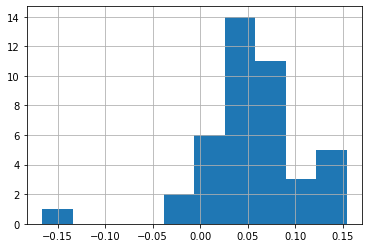

In [247]:



big_df.predicted_sector_performance.hist()

big_df.predicted_sector_performance.sum() / (len(big_df) / 12)



In [236]:


(big_df.correctly_chosen_sectors > 0).value_counts()



True     22
False    20
Name: correctly_chosen_sectors, dtype: int64

In [251]:


#big_df.actual_rets.sum() - big_df.predicted_sector_performance.sum()

mean_underperform_30_days = big_df.predicted_bottom_sector_performance.mean() 
mean_yearly_underperformance = mean_underperform_30_days * ((252 - forward)/forward)
mean_yearly_underperformance

big_df.predicted_bottom_sector_performance.sum() / (len(big_df) / 12)



-0.2568489893024206

In [375]:


#big_df.sort_values(by = "predicted_sector_performance")

#big_df


<AxesSubplot:xlabel='Date'>

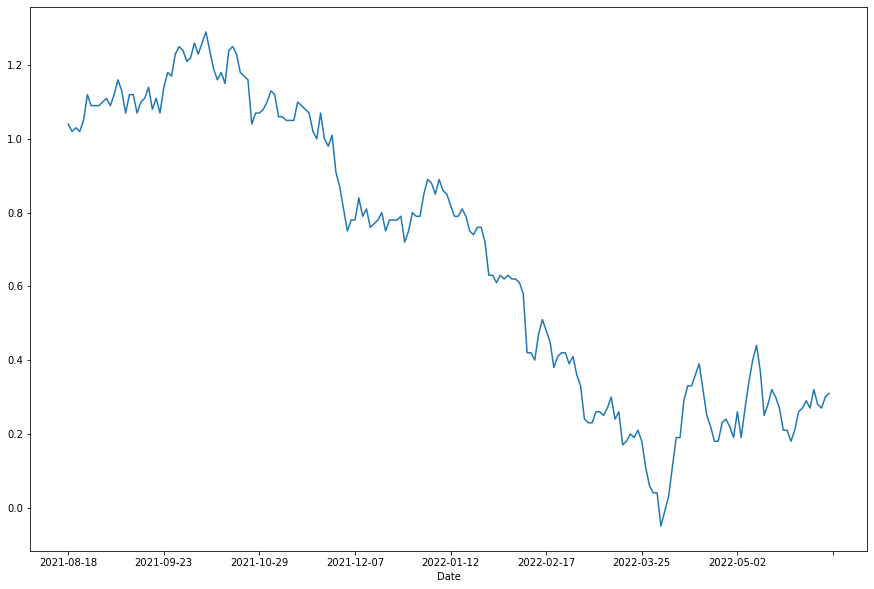

In [60]:



actual_returns.loc['2022-04']

combos = closest_combos((5,-1))


# .mean().sort_values()
# ['Aerospace']

real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()
#real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)][u.ut]

#combos

#sector_df['Real Yield'][-200:].plot(figsize = (15,10))
sector_df['Yield Curve'][-200:].plot(figsize = (15,10))


In [13]:

new_thing = pd.DataFrame()

new_rets = sector_df.copy()
new_rets.index = pd.to_datetime(new_rets.index)


In [14]:


actual_secs = []
actual_bottom_secs = []
actual_ret = []
predicted_sector_performance = []
predicted_bottom_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    dex = new_rets.loc[ (new_rets.index.month == d.month) & (new_rets.index.year == d.year)].index[0]

    if len(new_rets.loc[dex:]) >= forward:
        
        top_actual_secs = new_rets.loc[dex:].iloc[0:forward].pct_change().cumsum().iloc[-1][:-3].sort_values()
        actual_secs.append(top_actual_secs.index[-top_n_sectors:].to_list())
        actual_bottom_secs.append(top_actual_secs.index[:top_n_sectors].to_list())
        actual_ret.append(top_actual_secs[-top_n_sectors:].mean())
    
        predicted_sector_performance.append(top_actual_secs[list(big_df['pred_top_secs'].loc[str(d)])].mean())
        predicted_bottom_sector_performance.append(top_actual_secs[list(big_df['pred_bottom_secs'].loc[str(d)])].mean())

actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_bottom_secs = pd.Series(actual_bottom_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)

new_thing['actual_top_secs'] = actual_secs
new_thing['actual_bottom_secs'] = actual_bottom_secs
new_thing['actual_rets'] = actual_ret
new_thing['predicted_sector_performance'] = predicted_sector_performance
new_thing['predicted_bottom_sector_performance'] = predicted_bottom_sector_performance
new_thing = new_thing.dropna()



In [15]:


new_thing.predicted_sector_performance.sort_values()



2020-03   -0.222153
2022-04   -0.113456
2018-12   -0.105903
2019-05   -0.058598
2021-09   -0.045358
2020-06   -0.039167
2020-02   -0.029553
2020-09   -0.028409
2019-08   -0.025634
2019-07   -0.024178
2022-01   -0.023468
2022-02   -0.017785
2022-05   -0.011582
2020-10   -0.009084
2021-05    0.005851
2021-01    0.007594
2019-10    0.009790
2020-08    0.011902
2020-01    0.021611
2020-12    0.026772
2019-09    0.027880
2019-03    0.030725
2021-08    0.032827
2019-02    0.033886
2019-12    0.035501
2021-03    0.036395
2021-07    0.037992
2019-11    0.041715
2021-11    0.043659
2021-04    0.043740
2019-04    0.045636
2020-07    0.051182
2019-06    0.060452
2022-03    0.063967
2021-10    0.064798
2021-06    0.065615
2020-11    0.066264
2019-01    0.079234
2021-12    0.089537
2020-05    0.097340
2021-02    0.129318
2020-04    0.166486
Freq: M, Name: predicted_sector_performance, dtype: float64

In [16]:

#  * ((252 - forward)/forward)


new_thing.predicted_sector_performance.mean() * ((252 - forward)/forward)



0.18597025612271034

In [19]:

#big_df.predicted_sector_performance.mean() * ((252 - forward)/forward)

new_thing


,actual_top_secs,actual_bottom_secs,actual_rets,predicted_sector_performance,predicted_bottom_sector_performance
2018-12,[Telecomm],[Energy],-0.061573,-0.105903,-0.105867
2019-01,[Real Estate],[Utilities],0.116144,0.079234,0.031378
2019-02,[Technology],[Real Estate],0.065722,0.033886,0.039978
2019-03,[Real Estate],[Financials],0.046565,0.030725,0.018633
2019-04,[Telecomm],[Health Care],0.072206,0.045636,-0.000406
2019-05,[Utilities],[Technology],-0.004492,-0.058598,-0.004492
2019-06,[Technology],[Real Estate],0.105864,0.060452,0.074473
2019-07,[Technology],[Energy],0.005220,-0.024178,-0.014317
2019-08,[Real Estate],[Energy],0.035550,-0.025634,0.029206
2019-09,[Financials],[Real Estate],0.055347,0.027880,0.041960


In [17]:


# * ((252 - forward)/forward)

new_thing.predicted_bottom_sector_performance.mean()



0.007853259165172594

In [18]:




big_df.predicted_bottom_sector_performance.mean()




0.0034498557924698163

In [391]:
"""

MONTHLY DATA FOR FACTORS

"""

cutoff = .7

factor_df = pd.read_excel("factors_and_scores.xlsx", index_col="Date")

factor_train = factor_df[:int(len(factor_df)*cutoff)]
factor_test = factor_df[int(len(factor_df)*cutoff):]

#exposure = Rate_Exposures(train_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
for_scores = Rate_Exposures(sector_df, 252, forward, ['Real Yield', 'Yield Curve'])

# [int(len(u.get_monthly_data(sector_df))*cutoff):]
ry_scores_test_monthly = for_scores.monthly_scores['Real Yield']
yc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']
ry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]
yc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]


train_results_df = u.get_monthly_data(factor_train).copy()
train_results_df["ry_scores"] = round(train_results_df["ry_scores"], 0)
train_results_df["yc_scores"] = round(train_results_df["yc_scores"], 0)
#train_results_df

#rys = [i[0] for i in train_results_df.index]
#ycs = [i[1] for i in train_results_df.index]



In [296]:


buys = []
pred_above_market = []
exp_ret = []
top_n_sectors = 2

rates = [(i,j) for i,j in zip(train_results_df.ry_scores, train_results_df.yc_scores)]

for num, (ry, yc) in enumerate(zip(ry_scores_test_monthly, ry_scores_test_monthly)):
    
    if (ry, yc) in rates:
        
        ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
        buys.append(ok)
        
        exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())        
    
    elif ry in rys and yc not in ycs:
        
        up_yc = yc
        down_yc = yc
        
        while (ry, up_yc) not in rates and (ry, down_yc) not in rates:
            
            up_yc += 1
            down_yc -= 1
        
        if (ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(ry,down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].mean())        
    
    elif ry not in rys and yc in ycs:

        up_ry = ry
        down_ry = ry
        
        while (up_ry, yc) not in rates and (down_ry, yc) not in rates:
            
            up_ry += 1
            down_ry -= 1
        
        if (up_ry, yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry,yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (down_ry, yc) in rates:
            
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry,yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())
            

    else:
        
        up_yc = yc
        down_yc = yc
        up_ry = ry
        down_ry = ry
        
        while ((up_ry, up_yc) not in rates and (down_ry, down_yc) not in rates and 
               (up_ry, down_yc) not in rates and (down_ry, up_yc) not in rates):
            
            up_yc += 1
            down_yc -= 1
            up_ry += 1
            down_ry -= 1
        
        if (up_ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(up_ry, up_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry, up_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (down_ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(down_ry, down_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry, down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == down_ry)].mean().sort_values()[-top_n_sectors:].mean())

        
        elif (up_ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.iloc[:,:-2].loc[(up_ry, down_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry, down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == down_ry)].mean().sort_values()[-top_n_sectors:].mean())

        elif (down_ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(down_ry, up_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry, up_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
 
big_df = pd.DataFrame(index = ry_scores_test_monthly.index)
big_df['exp_rets_predicted'] = exp_ret
big_df['pred_top_secs'] = buys



In [310]:

factor_test = u.get_monthly_data(factor_test.iloc[:,:-2])

factor_test = factor_test.loc[ (factor_test.index >= "2018-11") & (factor_test.index <= "2021-11")]


In [315]:


actual_returns = factor_test



In [313]:

actual_secs = []
actual_secs_above_market = []
actual_ret = []
predicted_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    #print( big_df['pred_top_secs'])

    ok = set(actual_returns.loc[str(d)].sort_values().index[-top_n_sectors:].to_list())
    
    #set(train_results_df.loc[(ry,yc)].loc[train_results_df.loc[(ry,yc)] > 0.0].index.to_list())
    #ok_cool = set(actual_returns.loc[str(d)].loc[actual_returns.loc[str(d)] > 0.0].index.to_list())
    actual_secs.append(ok)
    #actual_secs_above_market.append(ok_cool)
    
    actual_ret.append(actual_returns.loc[str(d)].sort_values()[-top_n_sectors:].mean())
    
    
    #if d in expected_results.index:
    predicted_sector_performance.append(actual_returns.loc[str(d)][list(big_df['pred_top_secs'].loc[str(d)])].mean())


actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)

#actual_results = pd.DataFrame()
big_df['actual_secs'] = actual_secs
big_df['actual_rets'] = actual_ret
big_df = big_df.dropna()


In [317]:

correct_sectors = []
got_one_of_top_2_sectors = []
correct_sectors_above_market = []
mean_squared_error_return = []
return_error_regular = []

for pred, act in zip(big_df['pred_top_secs'], big_df['actual_secs']):
    
    sect = pred.intersection(act)
    correct_sectors.append(len(sect))
    
    if list(pred)[-1] == list(act)[-1]:
        got_one_of_top_2_sectors.append(1)
    else:
        got_one_of_top_2_sectors.append(0)
    
for pred, act in zip(big_df['exp_rets_predicted'], big_df['actual_rets']):
    
    mean_squared_error_return.append((pred-act)**2)
    return_error_regular.append(pred-act) 


correct_sectors = pd.Series(correct_sectors, index = big_df['exp_rets_predicted'].index)
got_one_of_top_2_sectors = pd.Series(got_one_of_top_2_sectors, index = big_df['exp_rets_predicted'].index)
mean_squared_error_return = pd.Series(mean_squared_error_return, index = big_df['exp_rets_predicted'].index)
return_error_regular = pd.Series(return_error_regular, index = big_df['exp_rets_predicted'].index)

big_df['correctly_chosen_sectors'] = correct_sectors
#big_df['correctly_chosen_sectors_above_market'] = correct_sectors_above_market
big_df['predicted_sector_performance'] = predicted_sector_performance
#big_df['correct_sector_performance'] = actual_results['actual_rets']
big_df['mean_squared_error_return_prediction'] = mean_squared_error_return
big_df['return_error_regular'] = return_error_regular

big_df = big_df.dropna()



In [323]:


big_df



,exp_rets_predicted,pred_top_secs,actual_secs,actual_rets,correctly_chosen_sectors,predicted_sector_performance,mean_squared_error_return_prediction,return_error_regular
2018-11,0.114544,"{QUALITY, CASH_TO_ASSETS}","{QUALITY, CASH_TO_ASSETS}",0.117929,2,0.117929,0.000011,-0.003385
2018-12,0.087087,"{QUALITY, CASH_TO_ASSETS}","{QUALITY, CASH_TO_ASSETS}",0.063237,2,0.063237,0.000569,0.023850
2019-01,0.054267,"{QUALITY, MOMENTUM}","{QUALITY, MOMENTUM}",0.066521,2,0.066521,0.000150,-0.012254
2019-02,0.064551,"{MOMENTUM, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.111022,1,-0.021956,0.002160,-0.046471
2019-03,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.215252,0,-0.268332,0.011589,-0.107652
2019-04,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.238507,0,-0.312435,0.017137,-0.130907
2019-05,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, CASH_TO_ASSETS}",0.184012,0,-0.224202,0.005839,-0.076411
2019-06,0.205168,"{QUALITY, MOMENTUM}","{SIZE, CASH_TO_ASSETS}",0.148375,0,-0.021055,0.003225,0.056793
2019-07,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{SIZE, CASH_TO_ASSETS}",0.205837,0,-0.104863,0.009650,-0.098236
2019-08,0.205168,"{QUALITY, MOMENTUM}","{SIZE, CASH_TO_ASSETS}",0.239083,0,-0.027407,0.001150,-0.033916


In [322]:



big_df.predicted_sector_performance




2018-11    0.117929
2018-12    0.063237
2019-01    0.066521
2019-02   -0.021956
2019-03   -0.268332
2019-04   -0.312435
2019-05   -0.224202
2019-06   -0.021055
2019-07   -0.104863
2019-08   -0.027407
2019-09   -0.065883
2019-10   -0.048110
2019-11   -0.048569
2019-12   -0.052217
2020-01    0.143324
2020-02    0.252584
2020-03   -0.016995
2020-04   -0.423995
2020-05    0.509024
2020-06    0.409819
2020-07   -0.267421
2020-08    0.400471
2020-09    0.052345
2020-10    0.077180
2020-11    0.131182
2020-12    0.161162
2021-01    0.188832
2021-02    0.018300
Freq: M, Name: predicted_sector_performance, dtype: float64